running matplotlib to initialize in jupyter notebook

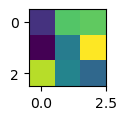

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
plt.figure(figsize=(2,1))
mat_img = np.random.rand(3,3)
plt.imshow(mat_img)

In [2]:
import torch 
from torch import nn

In [3]:
torch.__version__

'2.6.0+cu126'

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Get data

In [5]:
from pathlib import Path

train_dir = Path("asl_alphabet_train")
test_dir = Path("asl_alphabet_test")

train_dir, test_dir

(WindowsPath('asl_alphabet_train'), WindowsPath('asl_alphabet_test'))

## 2. Visualize an image

Random image path: asl_alphabet_train\P\P877.jpg
Image class: P
Image height: 200
Image width: 200


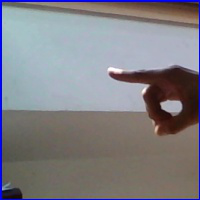

In [6]:
import random 
from PIL import Image

image_path_list = list(train_dir.glob("*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

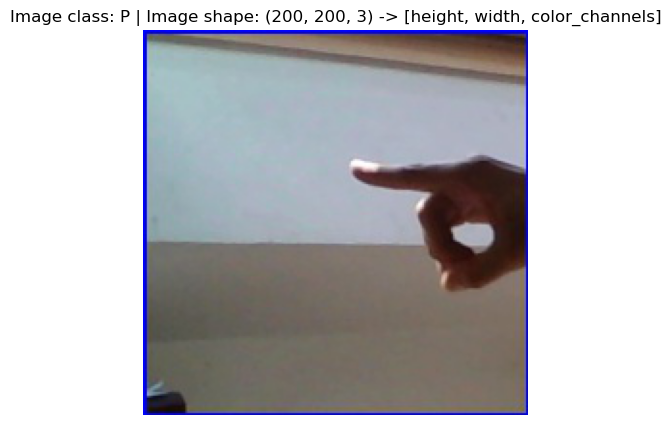

In [7]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array =np.asarray(img) 

plt.figure(figsize = (5, 5))
plt.imshow(img_as_array) 
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

# 3. Transforming data

In [8]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [9]:
transform = transforms.Compose([
    transforms.Resize(size = (64, 64)), 
    #transforms.RandomHorizontalFlip(p=0.5), 
    transforms.ToTensor(), 
    #transforms.Normalize((0.5,), (0.5,))  # Normalize (adjust if needed)
])

asl_alphabet_train\D\D1949.jpg
asl_alphabet_train\I\I1760.jpg
asl_alphabet_train\P\P457.jpg


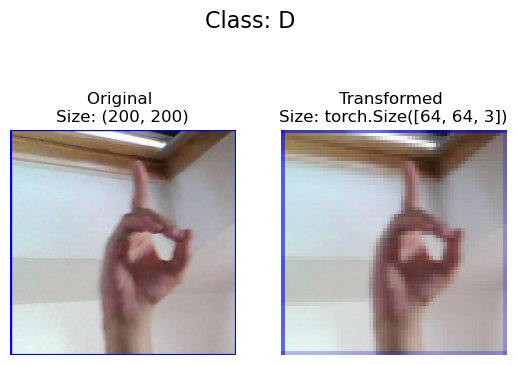

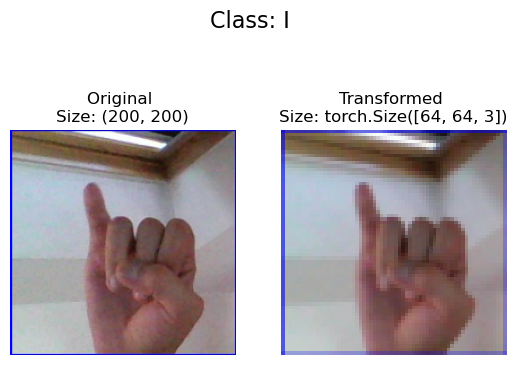

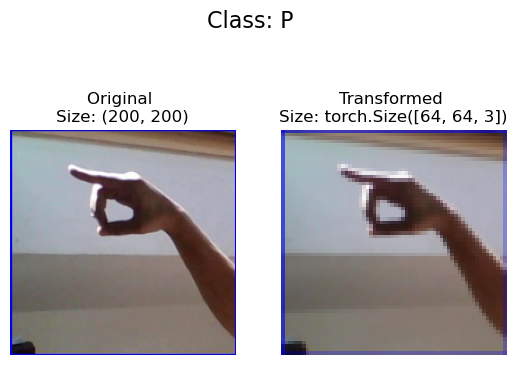

In [10]:
def plot_transformed_images(image_paths, transform, n=3):
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
            print(image_path)

plot_transformed_images(image_path_list, 
                        transform=transform, 
                        n=3)

## 4. Loading Image Data Using ImageFolder

In [11]:
train_dir, test_dir

(WindowsPath('asl_alphabet_train'), WindowsPath('asl_alphabet_test'))

In [12]:
import os
import shutil

root_dir = train_dir

for category in os.listdir(root_dir):
    checkpoint_path = os.path.join(root_dir, category, ".ipynb_checkpoints")
    if os.path.exists(checkpoint_path):
        shutil.rmtree(checkpoint_path)
        print(f"Deleted: {checkpoint_path}")

In [13]:
from torchvision import datasets
train_dataset = datasets.ImageFolder(root = train_dir, transform = transform)
test_dataset = datasets.ImageFolder(root = test_dir, transform = transform)

print(train_dataset, test_dataset)

Dataset ImageFolder
    Number of datapoints: 83997
    Root location: asl_alphabet_train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           ) Dataset ImageFolder
    Number of datapoints: 28
    Root location: asl_alphabet_test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [14]:
# Get class names as a list
class_names = train_dataset.classes
class_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'nothing',
 'space']

# 4.1 Turn loaded images into DataLoader's

In [15]:
from torch.utils.data import DataLoader, RandomSampler
import os

# Define variables
batch_size = 128  # You can adjust this based on your GPU memory
num_workers = min(4, os.cpu_count() // 2) + 1  # Optimize based on available CPU cores
pin_memory = True  # Set True if using GPU for faster data transfer

# Create a sampler that randomly picks 500 samples per class
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=RandomSampler(train_dataset, num_samples=500 * len(train_dataset.classes), replacement=False),
    num_workers=num_workers,
    pin_memory=pin_memory
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    sampler=RandomSampler(test_dataset, num_samples=len(test_dataset.classes), replacement=False),
    num_workers=num_workers,
    pin_memory=pin_memory
)

print()

In [16]:
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x1a02247ca00>,
 <torch.utils.data.dataloader.DataLoader at 0x1a02247ca30>)

In [17]:
img, label = next(iter(train_loader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([128, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([128])


In [18]:
len(train_loader) #batches in train_loader

110

## 5. Create TinyVGG model class 

In [19]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        #x = self.conv_block_1(x)
        ## print(x.shape)
        #x = self.conv_block_2(x)
        ## print(x.shape)
        #x = self.classifier(x)
        ## print(x.shape)
        #return x
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion


In [20]:
device

'cuda'

In [21]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape = 3, 
                  hidden_units = 10, 
                  output_shape = len(train_dataset.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=28, bias=True)
  )
)

### 6. Use torchinfo to get an idea of the shapes going through our model

In [22]:
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 28]                   --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## 7.1 Create train & test loop functions

In [23]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [24]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 7.2 Creating a train() function to combine train_step() and test_step()

In [25]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

## 7.3 Train and Evaluate Model 0

In [26]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 4

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=32, 
                  output_shape=len(train_dataset.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7805 | train_acc: 0.2003 | test_loss: 1.3463 | test_acc: 0.5714
Epoch: 2 | train_loss: 1.5520 | train_acc: 0.5285 | test_loss: 0.3665 | test_acc: 0.9286
Epoch: 3 | train_loss: 0.8543 | train_acc: 0.7337 | test_loss: 0.1219 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.5132 | train_acc: 0.8379 | test_loss: 0.0622 | test_acc: 1.0000
Total training time: 154.468 seconds


In [27]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "ASL-TinyVGG_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\ASL-TinyVGG_model.pth
